# Sand - PayU POC


In [72]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

techFile = '../data/domain-technologies.csv'
spendFile = '../data/domain-spend.csv'

tech_data = pd.read_csv(techFile)
spend_data = pd.read_csv(spendFile)

## Utilities


### Normalizaiton Utilities

In [73]:
import datetime
from dateutil.relativedelta import relativedelta

def ticks_to_datetime(ticks):
    #print('ticks_to_datetime: ', ticks)
    if pd.isna(ticks):
        return math.nan
    
    pyticks = ticks
    if len(str(ticks)) > 10: # JSON time ticks
        pyticks = int(ticks / 1000);
    
    return datetime.datetime.fromtimestamp(pyticks)


def add_months_to_datetime(dt, count):
    return dt + relativedelta(months=count)


### Slicing Utilities

In [74]:
#def total_technologies_per_domain(df, excludeTags):
#    return df.loc(df['Zipcode'] == zipcode & df['Sold year'] == sold_year)

def tech_for_domain(df, domain):
    return df.loc[df['Domain'] == domain]
    
def count_tech_per_domain(df, excludeTags):
    return df.groupby(['Domain']).size()

def count_tech_per_domain_and_subdomain(df, excludeTags):
    return df.groupby(['Domain','SubDomain']).size()

def spend_for_domain(df, domain):
    return df.loc[df['LookupDomain'] == domain]

### Plot Utilities


In [75]:
def view_table(df, count):
    return df.head(count).style.set_properties(**{'background-color': 'Light Grey', 'color': 'Black', 'border-color': 'white'})

def plot_count_over_time(df, title, timeCol, countCol, countLabel):
    data = {
        timeCol: df[timeCol].values,
        countCol: df[countCol].values
    }
        
    df = pd.DataFrame(data)
    #df['SpendDate'] = pd.to_datetime(df['SpendDate'])
    # Set SpendDate as the DataFrame index
    df.set_index(timeCol, inplace=True)

    # Generate a sequence of dates from the minimum to the maximum date in the DataFrame
    date_range = pd.date_range(df.index.min(), df.index.max(), freq='MS')

    # Reindex the DataFrame with the generated date range, filling missing values with the previous available value
    df = df.reindex(date_range, method='ffill')

    # Plot the SpendSum over time using a line plot
    df.plot(marker='.', linestyle='-', linewidth=2, markersize=6)

    # Customize the plot
    plt.xlabel('Time')
    plt.ylabel(countLabel)
    plt.title(title)

    # Show the plot
    plt.show()


startYear = 1970
def plot_spend_over_time_for_domains(df, domains):
    # Create plot index for all timestamps
    df_domains = df.loc[df['LookupDomain'].isin(domains)]
    df_domains.set_index('SpendDate', inplace=True)
    date_range = pd.date_range(df_domains.index.min(), df_domains.index.max(), freq='MS')
    
    # Create a plot
    plt.figure(figsize=(10, 6))
    
    for domain in domains:
        df_domain_i = df.loc[(df['LookupDomain'] == domain) & (df['SpendDate'].dt.year >= startYear)]

        data = {
            'SpendDate': df_domain_i['SpendDate'].values,
            'SpendSum': df_domain_i['SpendSum'].values
        }
        
        dfd = pd.DataFrame(data)
        dfd.set_index('SpendDate', inplace=True)
        startMonth = dfd.index.min()
        endMonth = add_months_to_datetime(dfd.index.max(),1)
        date_range = pd.date_range(startMonth, endMonth, freq='MS')
        dfd = dfd.reindex(date_range, method='ffill')
        
        #plt.plot(dfd['SpendSum'], marker='.', linestyle='-', linewidth=2, markersize=3, label=domain)
        plt.plot(dfd['SpendSum'], linestyle='-', linewidth=2, markersize=3, label=domain)

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Spend')
    plt.title('Average Monthly Spend $')

    # Add a legend with labels 'DF1' and 'DF2'
    plt.legend()

    # Show the plot
    plt.show()
    
    
def plot_tech_count_over_time_for_domains(df, domains):
    # Create plot index for all timestamps
    df_domains = df.loc[df['Domain'].isin(domains)]
    df_domains.set_index('Total', inplace=True)
    date_range = pd.date_range(df_domains.index.min(), df_domains.index.max(), freq='MS')
    
    # Create a plot
    plt.figure(figsize=(10, 6))
    
    for domain in domains:
        df_domain_i = df.loc[df['Domain'] == domain]

        data = {
            'LiveMonth': df_domain_i['LiveMonth'].values,
            'Total': df_domain_i['Total'].values
        }
        
        dfd = pd.DataFrame(data)
        dfd.set_index('LiveMonth', inplace=True)
        date_range = pd.date_range(dfd.index.min(), dfd.index.max(), freq='MS')
        dfd = dfd.reindex(date_range, method='ffill')
        
        plt.plot(dfd['Total'], marker='.', linestyle='-', linewidth=2, markersize=6, label=domain)
        
    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Technology Count')
    plt.title('Monthly Live Technology Count')

    # Add a legend with labels 'DF1' and 'DF2'
    plt.legend()

    # Show the plot
    plt.show()


## Overview


### Technology Data

In [76]:
view_table(tech_data,5)

,Domain,SubDomain,Url,FirstIndexed,LastIndexed,CompanyName,Vertical,State,Country,ARank,QRank,Name,Parent,FirstDetected,LastDetected,IsLive,IsPremium,Link,Tag,Category0,Category1,Category2,Category3,Category4,Category5,Category6,Category7,Category8,Category9
0,car4vip.com.pl,nan,nan,1566774000000,1688454000000,nan,nan,nan,nan,82279258,0,Home PL,nan,1566774000000,1688454000000,1,no,https://home.pl,hosting,Polish hosting,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,car4vip.com.pl,nan,nan,1566774000000,1688454000000,nan,nan,nan,nan,82279258,0,SPF,nan,1566774000000,1688454000000,1,no,http://www.open-spf.org/,mx,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,car4vip.com.pl,nan,nan,1566774000000,1688454000000,nan,nan,nan,nan,82279258,0,Home.pl DNS,nan,1567551600000,1688454000000,1,no,https://home.pl,ns,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,aldautomotive.pl,nan,nan,1073635200000,1689490800000,ALD Automotive Polska Sp. z o.o,Automotive And Vehicles,nan,PL,17482943,-1,Orange,nan,1389481200000,1393196400000,0,no,https://orange.com,hosting,French hosting,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,aldautomotive.pl,nan,nan,1073635200000,1689490800000,ALD Automotive Polska Sp. z o.o,Automotive And Vehicles,nan,PL,17482943,-1,IIS 6,IIS,1393196400000,1393196400000,0,no,https://www.iis.net,Web Server,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [77]:
# tech_data.describe()

### Spend Data

In [78]:
view_table(spend_data,5)

,LookupDomain,FirstIndexed,LastIndexed,SalesRevenue,SpendDate,SpendSum,CompanyName,Vertical,State,Country,ARank,QRank
0,aldautomotive.pl,1073635200000,1689490800000,0,1083899460000,0,ALD Automotive Polska Sp. z o.o,Automotive And Vehicles,nan,PL,17482943,-1
1,aldautomotive.pl,1073635200000,1689490800000,0,1410491460000,358,ALD Automotive Polska Sp. z o.o,Automotive And Vehicles,nan,PL,17482943,-1
2,aldautomotive.pl,1073635200000,1689490800000,0,1498619460000,1525,ALD Automotive Polska Sp. z o.o,Automotive And Vehicles,nan,PL,17482943,-1
3,aldautomotive.pl,1073635200000,1689490800000,0,1566011460000,1292,ALD Automotive Polska Sp. z o.o,Automotive And Vehicles,nan,PL,17482943,-1
4,aldautomotive.pl,1073635200000,1689490800000,0,1689490800000,1292,ALD Automotive Polska Sp. z o.o,Automotive And Vehicles,nan,PL,17482943,-1


In [79]:
# spend_data.describe()

### Normalization


In [80]:
### Normalize tech_data

# Convert json ticks to datetime
tech_data['FirstIndexed'] = tech_data['FirstIndexed'].apply(ticks_to_datetime)
tech_data['LastIndexed'] = tech_data['LastIndexed'].apply(ticks_to_datetime)
tech_data['FirstDetected'] = tech_data['FirstDetected'].apply(ticks_to_datetime)
tech_data['LastDetected'] = tech_data['LastDetected'].apply(ticks_to_datetime)


### Normalize spend_data

# Convert json ticks to datetime
spend_data['FirstIndexed'] = spend_data['FirstIndexed'].apply(ticks_to_datetime)
spend_data['LastIndexed'] = spend_data['LastIndexed'].apply(ticks_to_datetime)
spend_data['SpendDate'] = spend_data['SpendDate'].apply(ticks_to_datetime)

view_table(spend_data,3)



,LookupDomain,FirstIndexed,LastIndexed,SalesRevenue,SpendDate,SpendSum,CompanyName,Vertical,State,Country,ARank,QRank
0,aldautomotive.pl,2004-01-09 08:00:00,2023-07-16 07:00:00,0,2004-05-07 03:11:00,0,ALD Automotive Polska Sp. z o.o,Automotive And Vehicles,nan,PL,17482943,-1
1,aldautomotive.pl,2004-01-09 08:00:00,2023-07-16 07:00:00,0,2014-09-12 03:11:00,358,ALD Automotive Polska Sp. z o.o,Automotive And Vehicles,nan,PL,17482943,-1
2,aldautomotive.pl,2004-01-09 08:00:00,2023-07-16 07:00:00,0,2017-06-28 03:11:00,1525,ALD Automotive Polska Sp. z o.o,Automotive And Vehicles,nan,PL,17482943,-1


### Domain Verticals

In [81]:
domains_auto = ['car4vip.com.pl', 'carleasepolska.pl', 'aldautomotive.pl', 'businesslease.pl']
domains_travel = ['dreamworldtravel.co.uk', 'distantjourneys.co.uk', 'travel-stop.co.uk']
domains_fintech = ['usevirtus.com.br', 'zignet.com.br', 'koin.com.br', 'pagaleve.com.br']
domains_all = ['car4vip.com.pl', 'wypozyczalniasamochodowwwarszawie.pl', 'nobasiccars.com', 
                'edreamtravels.co.uk', 'dreamworldtravel.co.uk', 'dwtltd.com', 'al-umrah.com',
                'biznessclassflights.co.uk', 'bookholidaysonline.com', 'bookonlineflights.com',
                'detltd.com', 'usevirtus.com.br']

## Risk: Spend Analysis




### Spend over Time - All Domains

      LookupDomain           SpendDate  SpendSum
12  car4vip.com.pl 2019-09-18 10:20:00         0
13  car4vip.com.pl 2023-07-04 07:00:00         0 



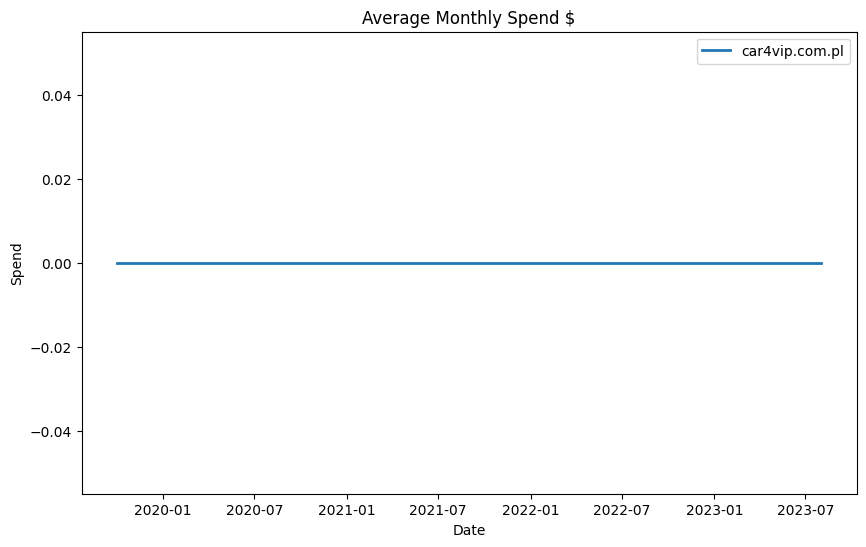

                            LookupDomain           SpendDate  SpendSum
16  wypozyczalniasamochodowwwarszawie.pl 2015-03-20 11:08:00         0
17  wypozyczalniasamochodowwwarszawie.pl 2023-07-15 07:00:00         0 



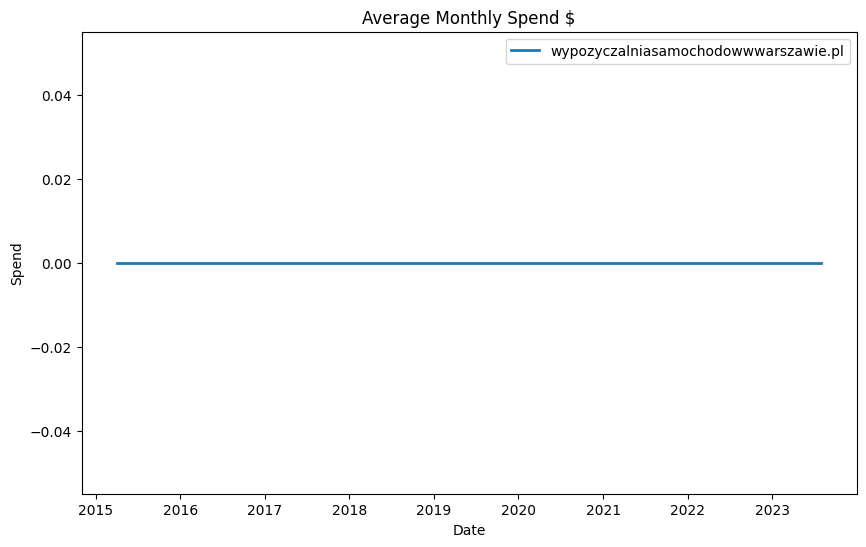

      LookupDomain  SpendDate  SpendSum
5  nobasiccars.com 1970-01-01         0 



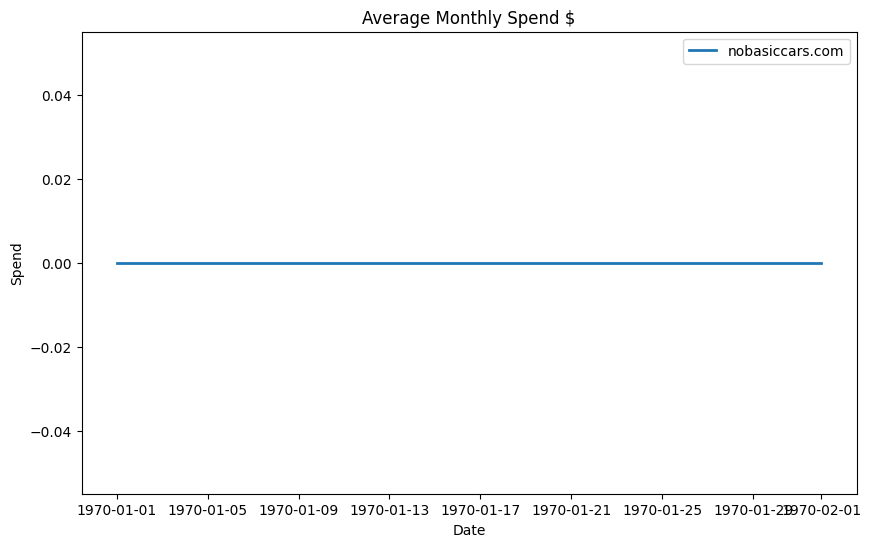

           LookupDomain           SpendDate  SpendSum
51  edreamtravels.co.uk 2022-10-22 09:00:00        80
52  edreamtravels.co.uk 2023-06-19 09:00:00         0
53  edreamtravels.co.uk 2023-06-20 07:00:00        80 



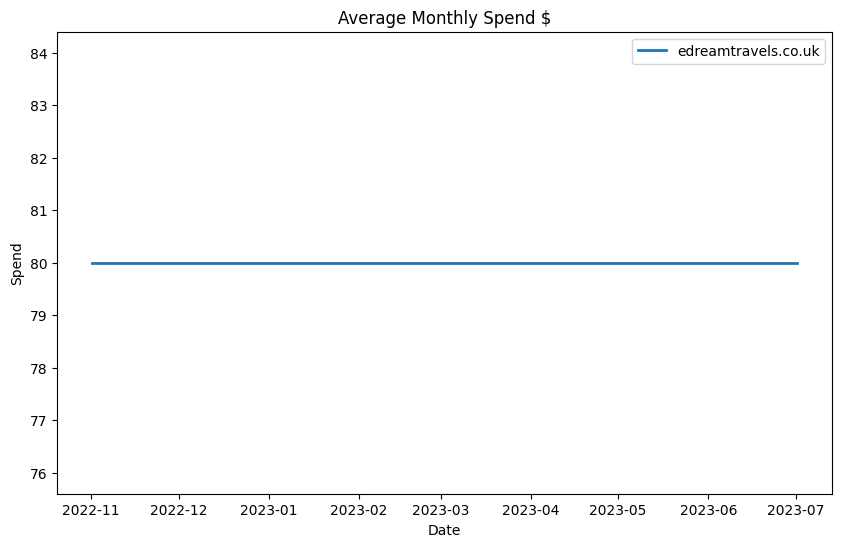

              LookupDomain           SpendDate  SpendSum
20  dreamworldtravel.co.uk 2014-10-28 19:45:00        21
21  dreamworldtravel.co.uk 2019-10-02 19:45:00        75
22  dreamworldtravel.co.uk 2021-09-21 19:45:00       172
23  dreamworldtravel.co.uk 2022-09-16 19:45:00       151
24  dreamworldtravel.co.uk 2023-05-14 19:45:00         0
25  dreamworldtravel.co.uk 2023-07-14 07:00:00       151 



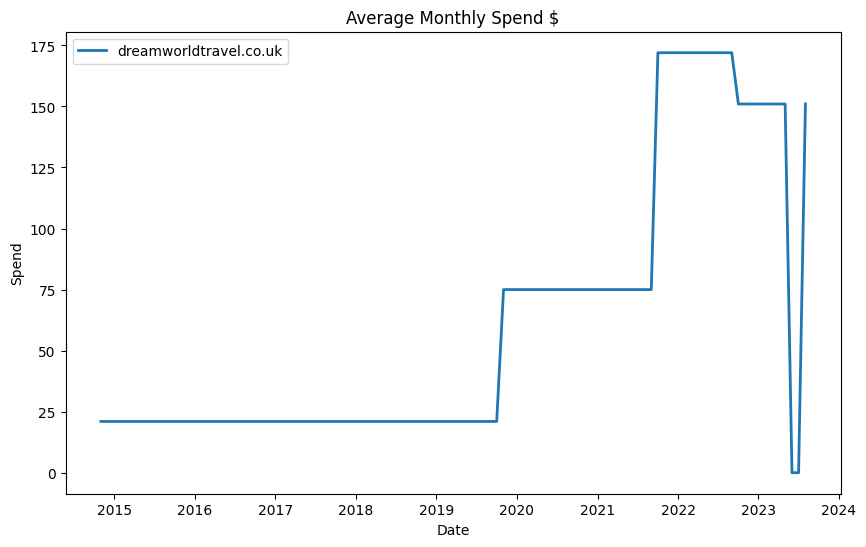

   LookupDomain           SpendDate  SpendSum
54   dwtltd.com 2013-05-02 13:18:00         0
55   dwtltd.com 2013-08-30 13:18:00        21
56   dwtltd.com 2023-07-07 07:00:00         0 



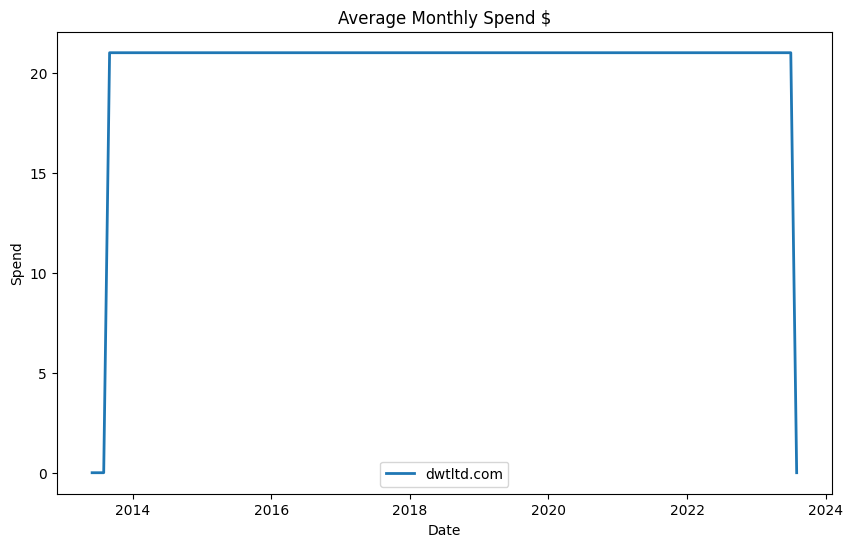

    LookupDomain           SpendDate  SpendSum
14  al-umrah.com 2016-06-13 23:08:00         0
15  al-umrah.com 2022-10-02 07:00:00         0 



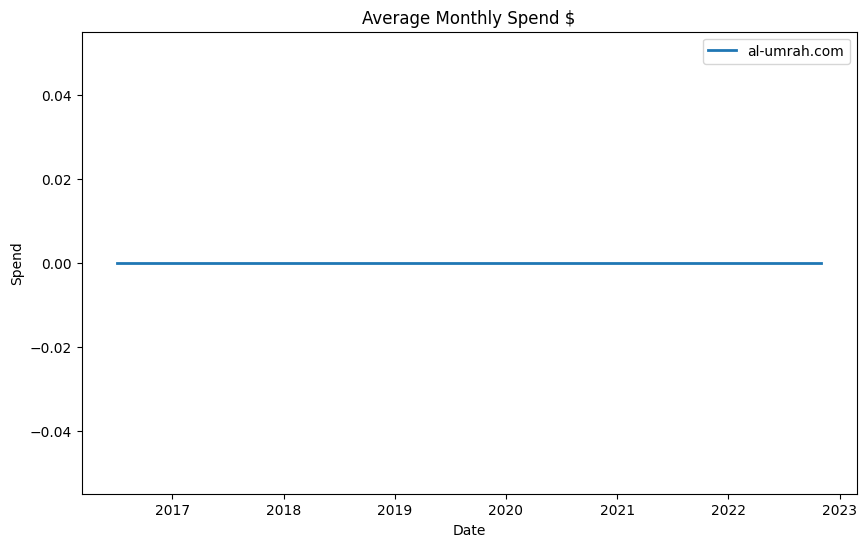

                 LookupDomain           SpendDate  SpendSum
57  biznessclassflights.co.uk 2020-10-03 04:44:00         0
58  biznessclassflights.co.uk 2023-03-21 07:00:00         0 



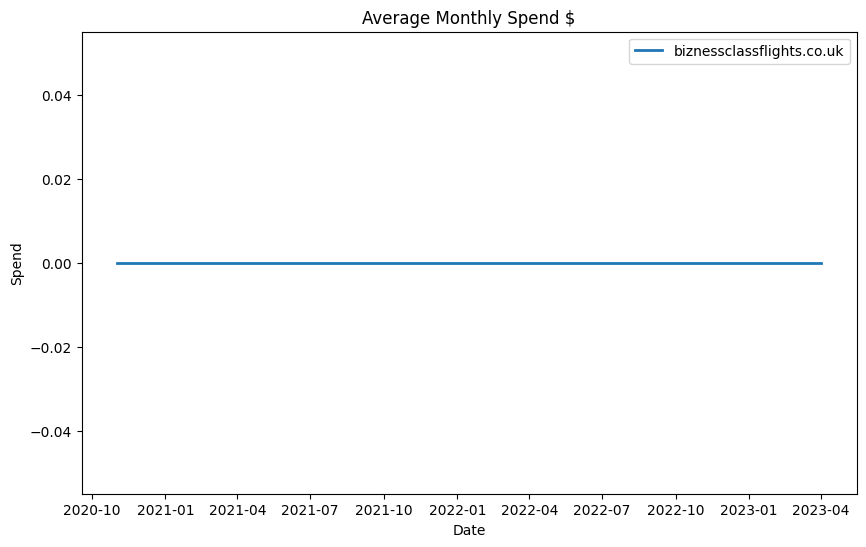

              LookupDomain           SpendDate  SpendSum
33  bookholidaysonline.com 2016-03-16 09:08:00         0
34  bookholidaysonline.com 2023-03-22 07:00:00         0 



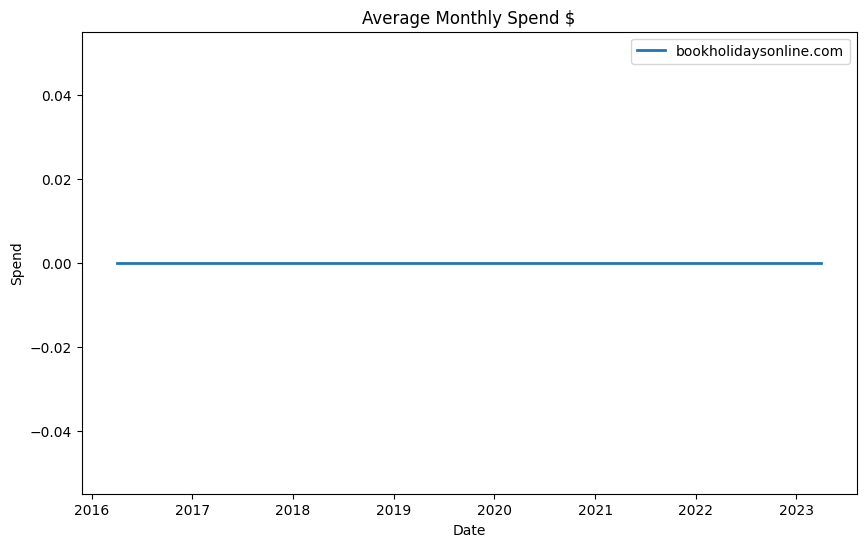

             LookupDomain           SpendDate  SpendSum
18  bookonlineflights.com 2014-03-08 01:57:00         0
19  bookonlineflights.com 2023-02-01 08:00:00         0 



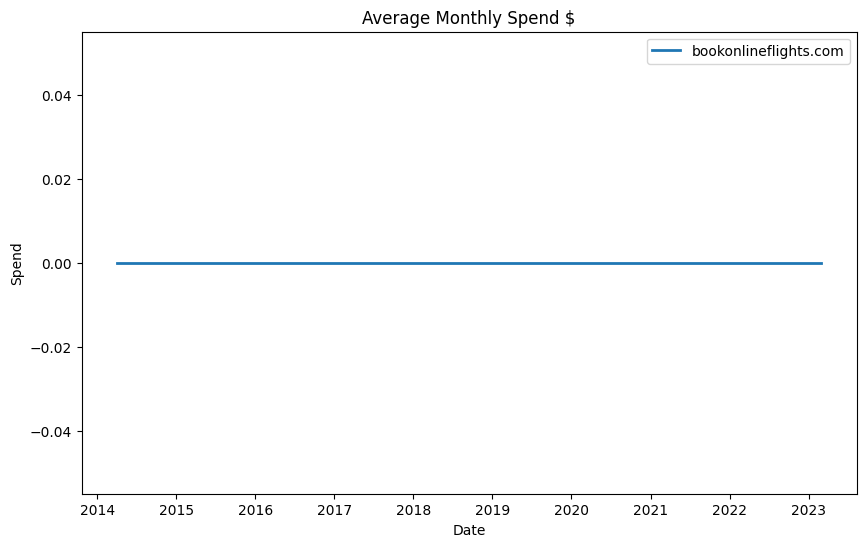

   LookupDomain           SpendDate  SpendSum
69   detltd.com 2019-09-18 02:20:00         0
70   detltd.com 2023-06-14 07:00:00         0 



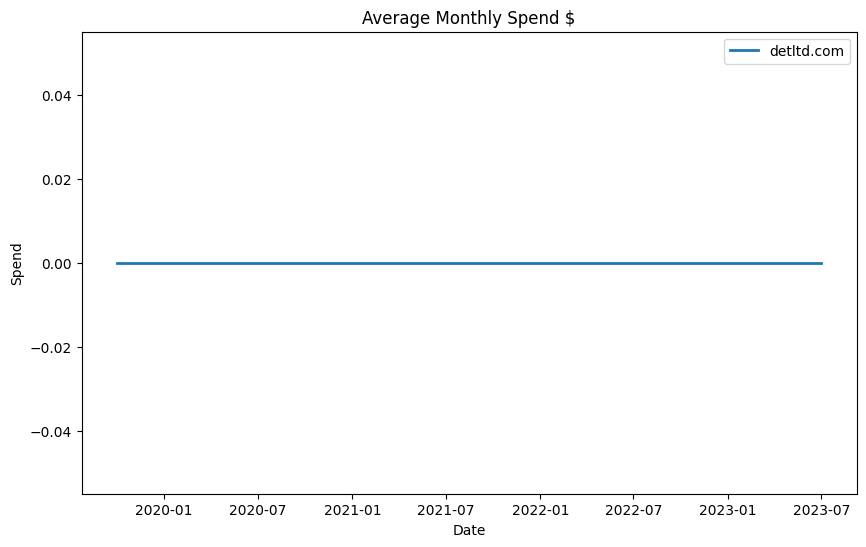

        LookupDomain           SpendDate  SpendSum
35  usevirtus.com.br 2017-07-11 04:44:00       447
36  usevirtus.com.br 2019-01-02 04:44:00       230
37  usevirtus.com.br 2019-03-03 04:44:00       343
38  usevirtus.com.br 2019-08-30 04:44:00         0
39  usevirtus.com.br 2019-10-29 04:44:00       317
40  usevirtus.com.br 2020-02-26 04:44:00       839
41  usevirtus.com.br 2020-12-22 04:44:00       895
42  usevirtus.com.br 2021-06-20 04:44:00       949
43  usevirtus.com.br 2021-10-18 04:44:00      1413
44  usevirtus.com.br 2021-12-17 04:44:00      1046
45  usevirtus.com.br 2022-06-15 04:44:00      1379
46  usevirtus.com.br 2022-08-14 04:44:00      1262
47  usevirtus.com.br 2023-02-10 04:44:00      1443
48  usevirtus.com.br 2023-04-11 04:44:00      1232
49  usevirtus.com.br 2023-06-10 04:44:00      1468
50  usevirtus.com.br 2023-07-17 07:00:00      2145 



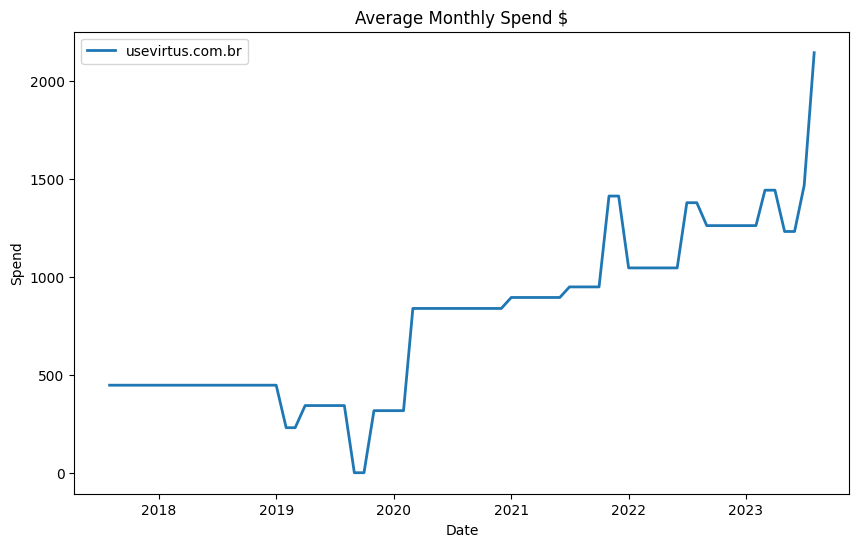

In [83]:
for domain in domains_all:
    sd_for_domain = spend_data.loc[spend_data['LookupDomain'] == domain]
    print(sd_for_domain[['LookupDomain', 'SpendDate', 'SpendSum']], '\n')
    plot_spend_over_time_for_domains(spend_data, [domain])

### Spend over Time - Automotive

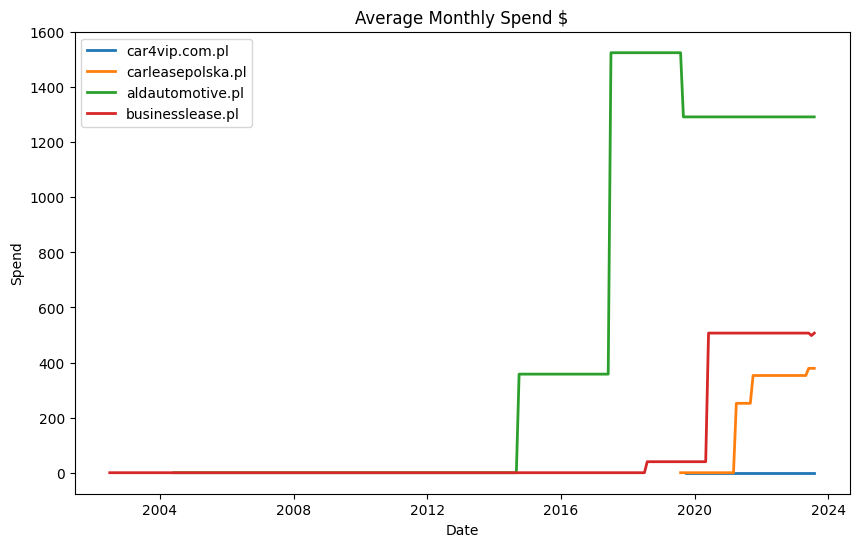

In [84]:
plot_spend_over_time_for_domains(spend_data, domains_auto)

### Spend over Time - Travel


2010-03-10 20:23:00 2023-07-15 07:00:00


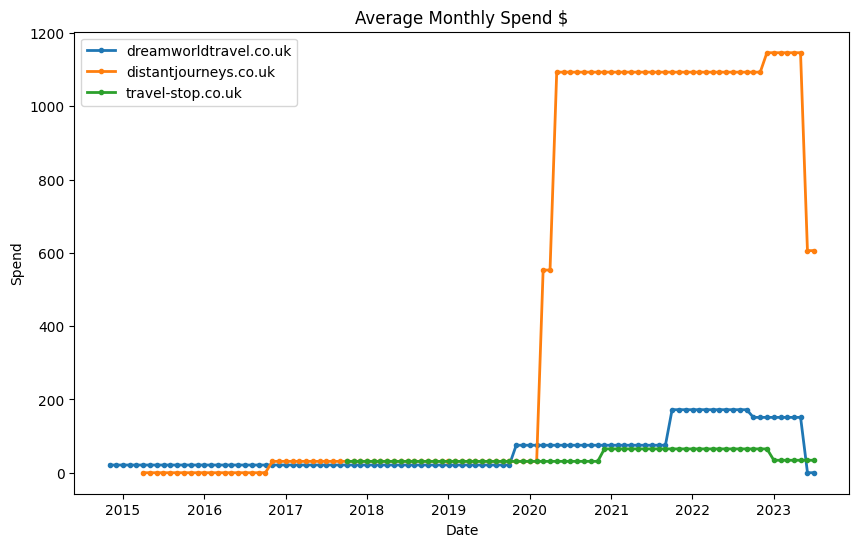

In [90]:
plot_spend_over_time_for_domains(spend_data, domains_travel)

### Spend over Time - Fintech

2005-07-05 13:08:00 2023-07-17 07:00:00


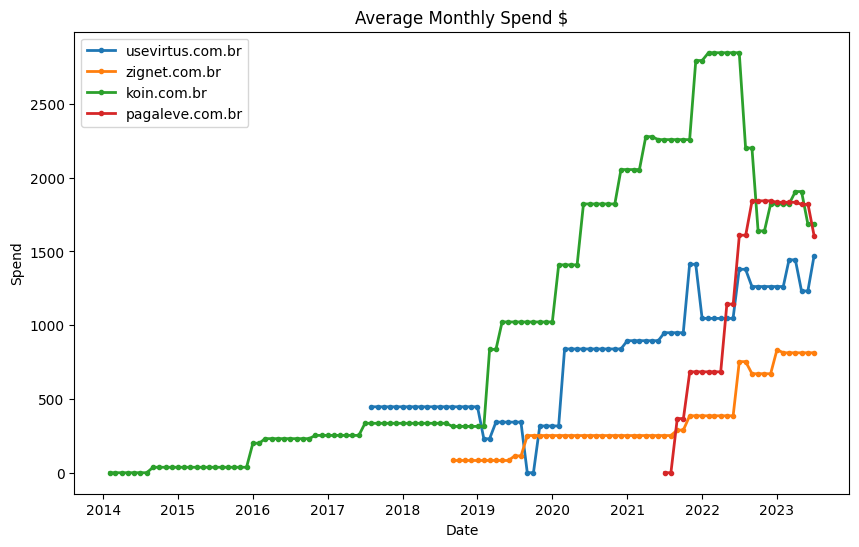

In [91]:
plot_spend_over_time_for_domains(spend_data, domains_fintech)

### Add SpendChange and RollingSpendChange columns

In [92]:
def add_spend_change(df):
    df = df.sort_values(by=['LookupDomain', 'SpendDate'])
    df['SpendChange'] = df.groupby('LookupDomain')['SpendSum'].pct_change()
    return df

def add_rolling_spend_change(df, window):
    df = df.sort_values(by=['LookupDomain', 'SpendDate'])
    df['RollingSpendChange'] = df.groupby('LookupDomain')['SpendSum'].pct_change(periods=window)
    return df

spend_data = add_spend_change(spend_data)

window = 2  # Specify the window size for the rolling calculation
spend_data = add_rolling_spend_change(spend_data, window)

view_table(spend_data,5)


,LookupDomain,FirstIndexed,LastIndexed,SalesRevenue,SpendDate,SpendSum,CompanyName,Vertical,State,Country,ARank,QRank,SpendChange,RollingSpendChange
6,al-umrah.com,2016-05-05 23:00:00,2022-10-02 07:00:00,0,2016-06-13 23:08:00,0,nan,nan,nan,nan,42277261,0,nan,nan
7,al-umrah.com,2016-05-05 23:00:00,2022-10-02 07:00:00,0,2022-10-02 07:00:00,0,nan,nan,nan,nan,42277261,0,nan,nan
63,aldautomotive.pl,2004-01-09 08:00:00,2023-07-16 07:00:00,0,2004-05-07 03:11:00,0,ALD Automotive Polska Sp. z o.o,Automotive And Vehicles,nan,PL,17482943,-1,nan,nan
64,aldautomotive.pl,2004-01-09 08:00:00,2023-07-16 07:00:00,0,2014-09-12 03:11:00,358,ALD Automotive Polska Sp. z o.o,Automotive And Vehicles,nan,PL,17482943,-1,inf,nan
65,aldautomotive.pl,2004-01-09 08:00:00,2023-07-16 07:00:00,0,2017-06-28 03:11:00,1525,ALD Automotive Polska Sp. z o.o,Automotive And Vehicles,nan,PL,17482943,-1,3.259777,inf


### Domains with Decreased Spend - Based on SpendChange


In [93]:
threshold = -0.25  # 25% decrease or more

decreased_spend_domains = spend_data.loc[spend_data['SpendChange'] <= threshold]['LookupDomain'].unique()

print(decreased_spend_domains)

['carleasepolska.pl' 'destinology.co.uk' 'distantjourneys.co.uk'
 'dreamworldtravel.co.uk' 'dwtltd.com' 'edreamtravels.co.uk' 'koin.com.br'
 'travel-stop.co.uk' 'usevirtus.com.br']


[  0 252 353 379 279 379]


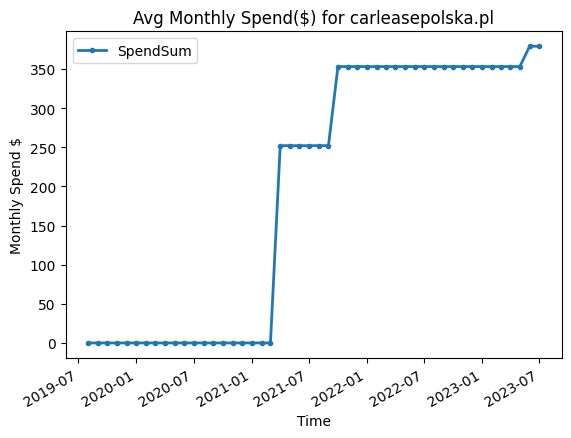

[   0  466  564  616 1036 2736 2921 2454 2511 1247  529  685  772  998
 1812 1780 1897 1957 2180 2063 1951 1411 1444 1756 1854 2008 2268 2246
  879 2375]


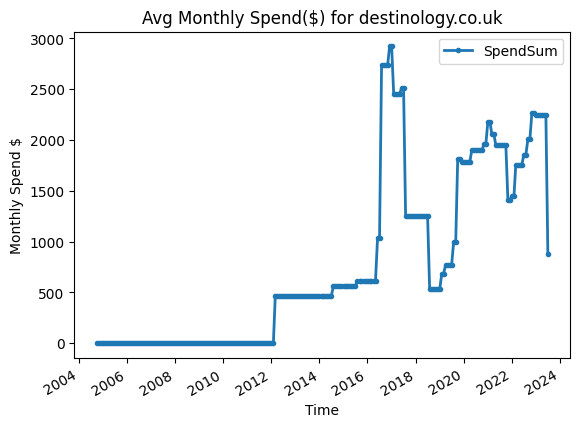

[   0   31  553 1093 1146  606 1146]


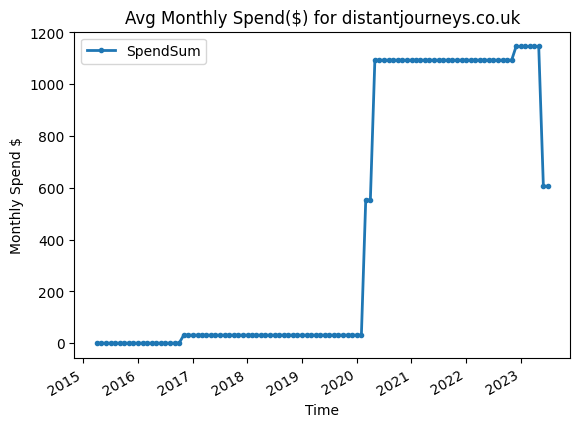

[ 21  75 172 151   0 151]


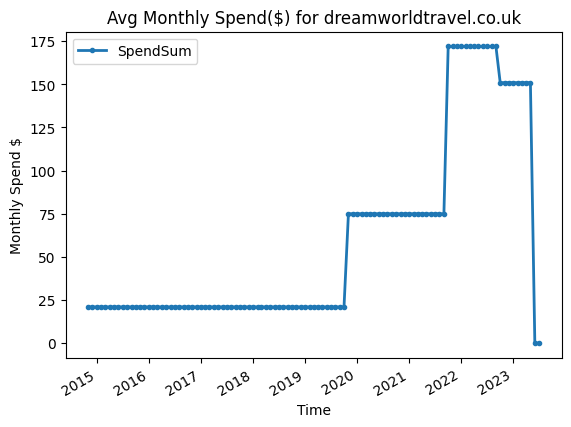

[ 0 21  0]


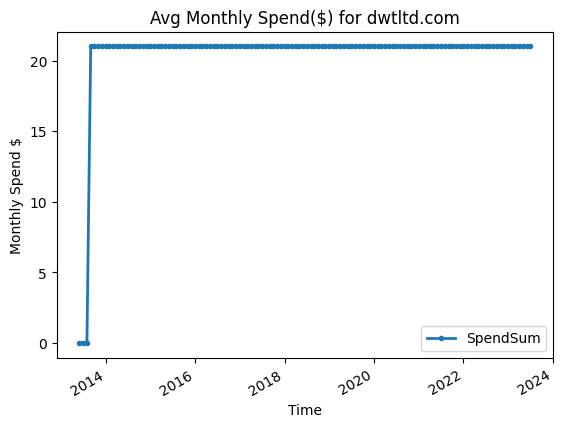

[80  0 80]


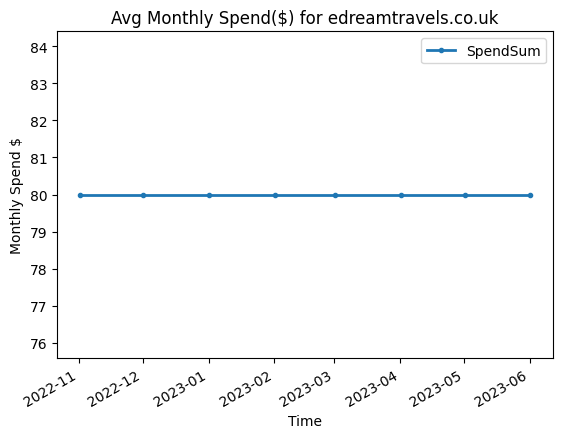

[   0   37  200  231  253  335  314  836 1022 1409 1822 2055 2278 2258
 2794 2847 2201 1639 1821 1906 1684 2131]


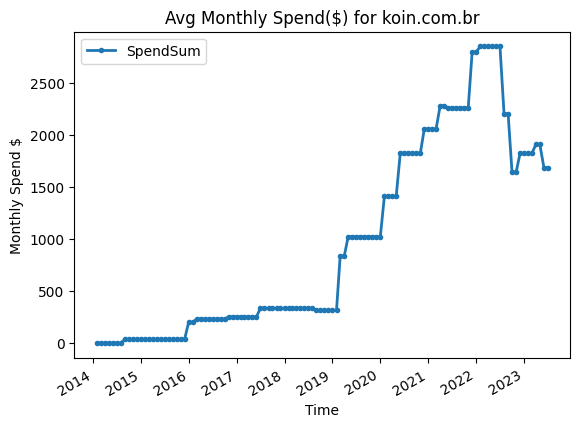

[ 0 31 65 34 34]


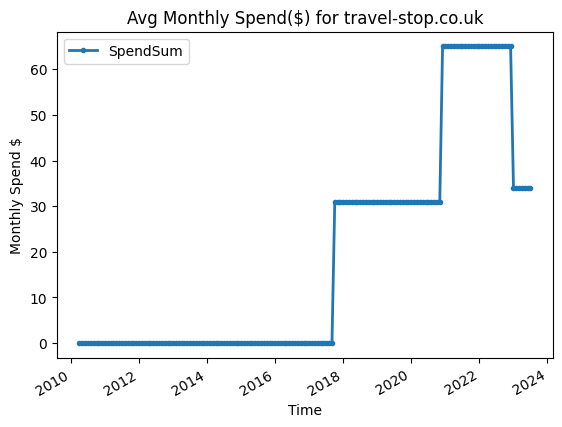

[ 447  230  343    0  317  839  895  949 1413 1046 1379 1262 1443 1232
 1468 2145]


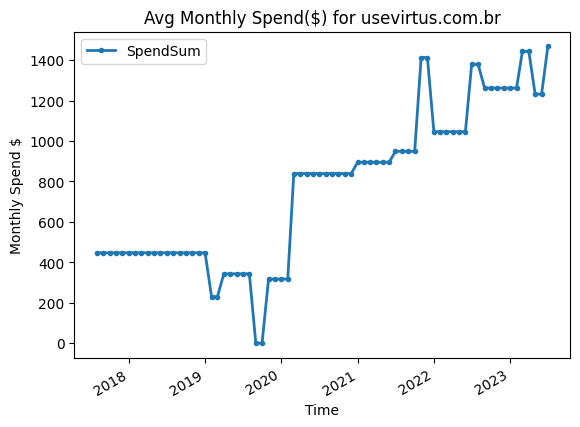

In [94]:
for domain in decreased_spend_domains:
    sd_for_domain = spend_data.loc[spend_data['LookupDomain'] == domain]
    print(sd_for_domain['SpendSum'].values)
    plot_count_over_time(sd_for_domain, 'Avg Monthly Spend($) for ' + domain, 'SpendDate', 'SpendSum', 'Monthly Spend $')
    

### Domains with Decreased Spend - Based on RollingSpendChange


In [95]:
threshold = -0.25  # 25% decrease or more

decreased_rolling_spend_domains = spend_data.loc[spend_data['RollingSpendChange'] <= threshold]['LookupDomain'].unique()

print(decreased_rolling_spend_domains)

['destinology.co.uk' 'distantjourneys.co.uk' 'dreamworldtravel.co.uk'
 'koin.com.br' 'travel-stop.co.uk' 'usevirtus.com.br']


#### Plot Decreased Spending

[   0  466  564  616 1036 2736 2921 2454 2511 1247  529  685  772  998
 1812 1780 1897 1957 2180 2063 1951 1411 1444 1756 1854 2008 2268 2246
  879 2375]


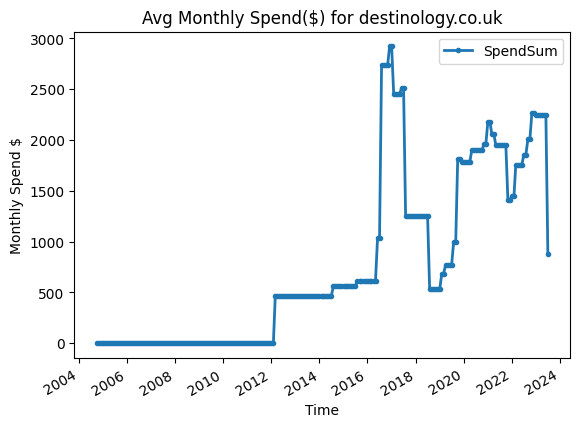

[   0   31  553 1093 1146  606 1146]


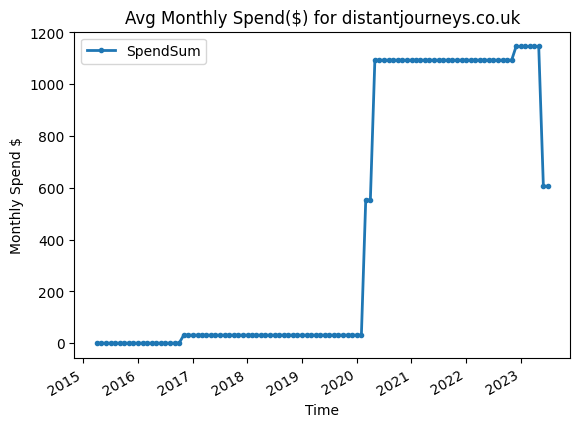

[ 21  75 172 151   0 151]


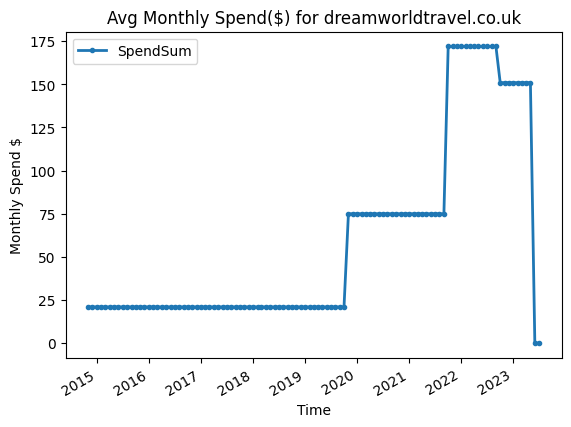

[   0   37  200  231  253  335  314  836 1022 1409 1822 2055 2278 2258
 2794 2847 2201 1639 1821 1906 1684 2131]


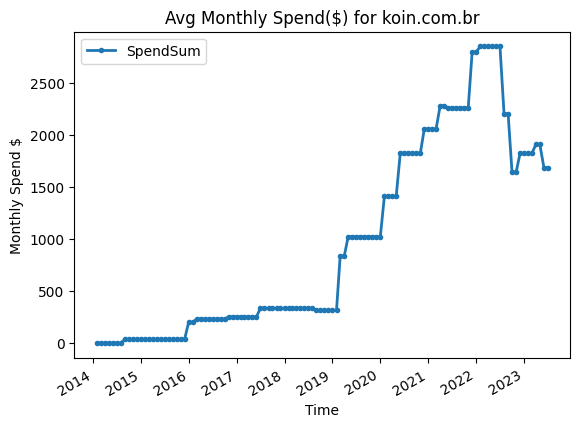

[ 0 31 65 34 34]


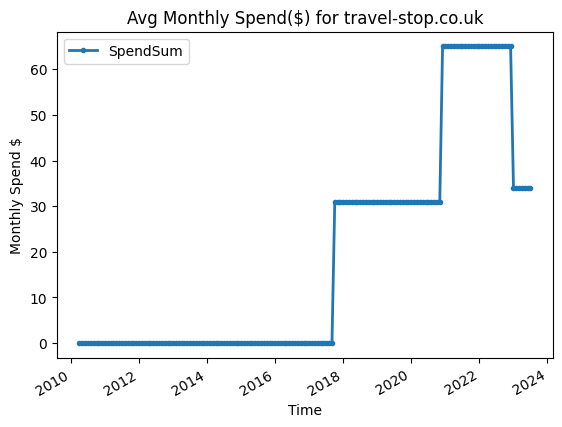

[ 447  230  343    0  317  839  895  949 1413 1046 1379 1262 1443 1232
 1468 2145]


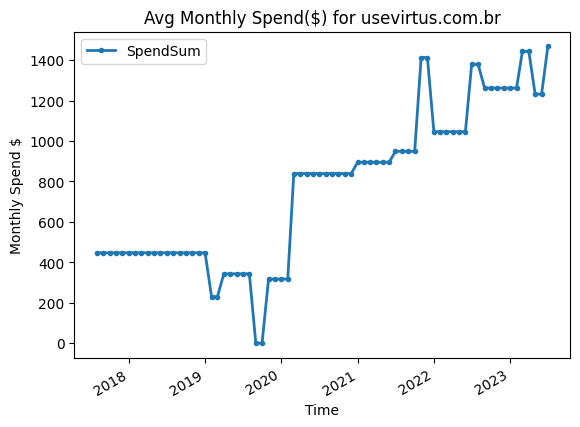

In [96]:
for domain in decreased_rolling_spend_domains:
    sd_for_domain = spend_data.loc[spend_data['LookupDomain'] == domain]
    print(sd_for_domain['SpendSum'].values)
    plot_count_over_time(sd_for_domain, 'Avg Monthly Spend($) for ' + domain, 'SpendDate', 'SpendSum', 'Monthly Spend $')
    

## Technology Usage Analysis


In [97]:
bw_tech_tags = [ 'ads', 'widgets', 'analytics', 'shop', 'feeds', 'javascript', 'cms', 'Web Master', 'seo_headers', 'framework', 'cdns', 'payment', 'parked', 'encoding', 'mobile', 'mapping', 'Server', 'mx', 'ssl', 'link', 'hosting', 'seo_title', 'CDN', 'seo_meta', 'ns', 'shipping', 'language', 'copyright', 'robots', 'registrar']
included_tech_tags = [ 'ads', 'widgets', 'analytics', 'shop', 'feeds', 'cms', 'seo_headers','cdns', 'payment', 'parked', 'encoding', 'mobile', 'mapping', 'Server', 'mx', 'ssl', 'link', 'hosting', 'seo_title', 'CDN', 'seo_meta', 'ns', 'shipping', 'language', 'copyright', 'robots', 'registrar']


### NOTE ###
# Exclude in category level instead of tag
############


### Create Monthly Live Tech Table

In [98]:

def create_monthly_live_tech_data(df):
   # Initialize an empty list to store rows for the new DataFrame
    new_rows = []

    # Iterate over each row in the original DataFrame
    for _, row in df.iterrows():
        startDate = row['FirstDetected'].replace(minute=0, hour=0, second=0)
        endDate = add_months_to_datetime(row['LastDetected'],1).replace(minute=0, hour=0, second=0)
        date_range = pd.date_range(startDate, endDate , freq='M')
        tech_activity = pd.DataFrame({
            'Domain': [row['Domain']] * len(date_range),
            'DubDomain': [row['Domain']] * len(date_range),
            'Url': [row['Url']] * len(date_range),
            'FirstIndexed': [row['FirstIndexed']] * len(date_range),
            'LastIndexed': [row['LastIndexed']] * len(date_range),
            'CompanyName': [row['CompanyName']] * len(date_range),
            'Vertical': [row['Vertical']] * len(date_range),
            'Country': [row['Country']] * len(date_range),
            'Name': [row['Name']] * len(date_range),
            'Parent': [row['Parent']] * len(date_range),
            'FirstDetected': [row['FirstDetected']] * len(date_range),
            'LastDetected': [row['LastDetected']] * len(date_range),
            'IsPremium': [row['IsPremium']] * len(date_range),
            'LiveMonth': date_range,
            'Tag': [row['Tag']] * len(date_range),
            'Category0': [row['Category0']] * len(date_range),
            'Category1': [row['Category1']] * len(date_range),
            'Category2': [row['Category2']] * len(date_range),
            'Category3': [row['Category3']] * len(date_range),
            'Category4': [row['Category4']] * len(date_range),
            'Category5': [row['Category5']] * len(date_range),
            'Category6': [row['Category6']] * len(date_range),
            'Category7': [row['Category7']] * len(date_range),
            'Category8': [row['Category8']] * len(date_range),
            'Category9': [row['Category9']] * len(date_range),
        })

        new_rows.append(tech_activity)

    # Concatenate all rows to create the new DataFrame
    new_df = pd.concat(new_rows, ignore_index=True)

    return new_df

# Monthly live tech data
monthly_active_tech_data = create_monthly_live_tech_data(tech_data)

# Mothly live tech data excluding redundant tech
tech_included_tags_data = tech_data[tech_data['Tag'].isin(included_tech_tags)] 
monthly_active_included_tech_data = create_monthly_live_tech_data(tech_included_tags_data)

view_table(monthly_active_tech_data,3)


,Domain,DubDomain,Url,FirstIndexed,LastIndexed,CompanyName,Vertical,Country,Name,Parent,FirstDetected,LastDetected,IsPremium,LiveMonth,Tag,Category0,Category1,Category2,Category3,Category4,Category5,Category6,Category7,Category8,Category9
0,car4vip.com.pl,car4vip.com.pl,nan,2019-08-25 23:00:00,2023-07-04 07:00:00,nan,nan,nan,Home PL,nan,2019-08-25 23:00:00,2023-07-04 07:00:00,no,2019-08-31 00:00:00,hosting,Polish hosting,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,car4vip.com.pl,car4vip.com.pl,nan,2019-08-25 23:00:00,2023-07-04 07:00:00,nan,nan,nan,Home PL,nan,2019-08-25 23:00:00,2023-07-04 07:00:00,no,2019-09-30 00:00:00,hosting,Polish hosting,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,car4vip.com.pl,car4vip.com.pl,nan,2019-08-25 23:00:00,2023-07-04 07:00:00,nan,nan,nan,Home PL,nan,2019-08-25 23:00:00,2023-07-04 07:00:00,no,2019-10-31 00:00:00,hosting,Polish hosting,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [99]:
view_table(monthly_active_included_tech_data,3)


,Domain,DubDomain,Url,FirstIndexed,LastIndexed,CompanyName,Vertical,Country,Name,Parent,FirstDetected,LastDetected,IsPremium,LiveMonth,Tag,Category0,Category1,Category2,Category3,Category4,Category5,Category6,Category7,Category8,Category9
0,car4vip.com.pl,car4vip.com.pl,nan,2019-08-25 23:00:00,2023-07-04 07:00:00,nan,nan,nan,Home PL,nan,2019-08-25 23:00:00,2023-07-04 07:00:00,no,2019-08-31 00:00:00,hosting,Polish hosting,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,car4vip.com.pl,car4vip.com.pl,nan,2019-08-25 23:00:00,2023-07-04 07:00:00,nan,nan,nan,Home PL,nan,2019-08-25 23:00:00,2023-07-04 07:00:00,no,2019-09-30 00:00:00,hosting,Polish hosting,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,car4vip.com.pl,car4vip.com.pl,nan,2019-08-25 23:00:00,2023-07-04 07:00:00,nan,nan,nan,Home PL,nan,2019-08-25 23:00:00,2023-07-04 07:00:00,no,2019-10-31 00:00:00,hosting,Polish hosting,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [100]:
# Calc Table: [Domain, LiveMonth, Premium_yes, Premium_no, Premium_maybe, Total ]

def create_premium_count_dataframe(df):
    # Pivot the DataFrame to create separate columns for each unique value in 'IsPremium' column
    pivoted_df = df.pivot_table(index=['Domain', 'LiveMonth'], columns='IsPremium', aggfunc='size', fill_value=0)

    # Reset the index and rename the columns
    pivoted_df = pivoted_df.reset_index().rename_axis(None, axis=1)

    # Rename the columns to include 'PremiumCount_' prefix
    pivoted_df.columns = ['Domain', 'LiveMonth'] + ['Premium_' + str(col) for col in pivoted_df.columns[2:]]
    
    pivoted_df['Total'] = pivoted_df['Premium_yes'] + pivoted_df['Premium_no'] + pivoted_df['Premium_maybe']

    return pivoted_df


premium_count_data = create_premium_count_dataframe(monthly_active_tech_data)

In [101]:
### Technology Usage - Per Domain

/home/vscode/.local/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


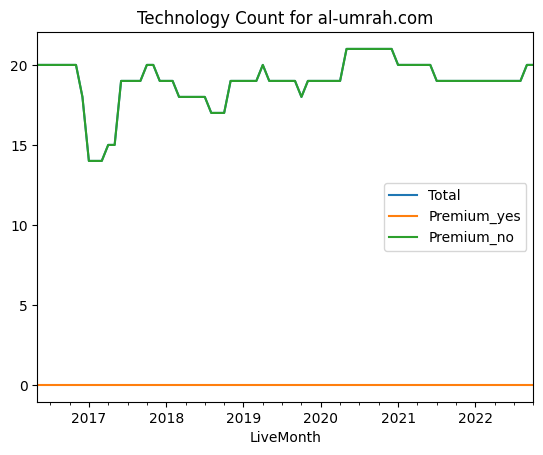

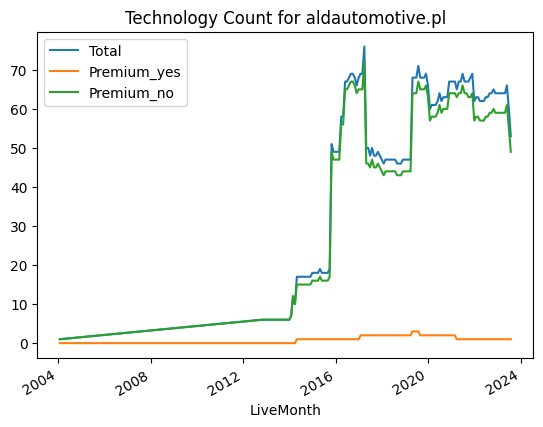

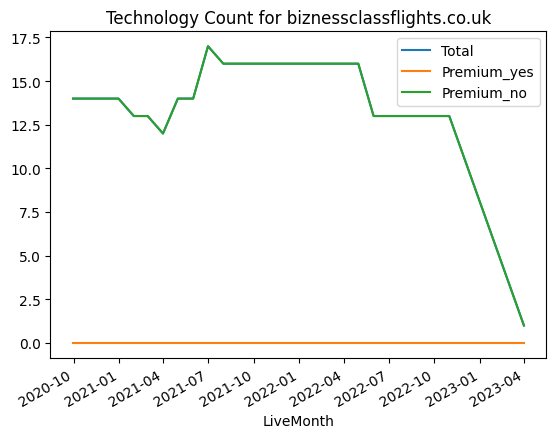

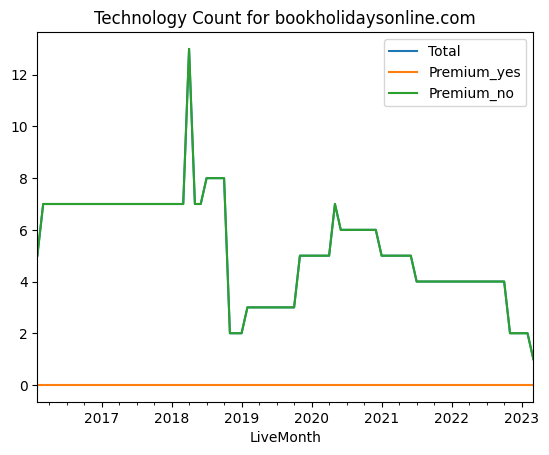

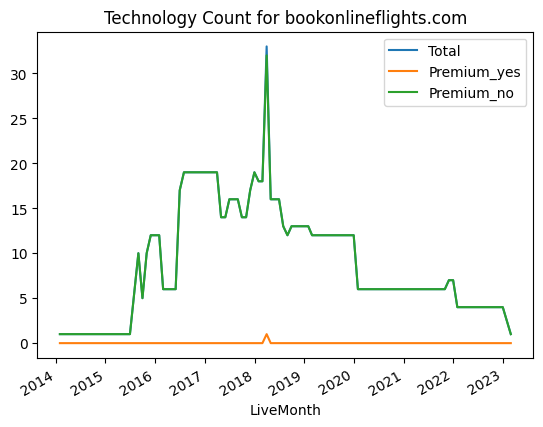

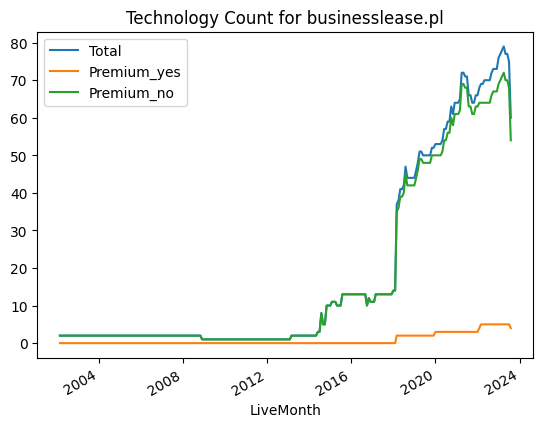

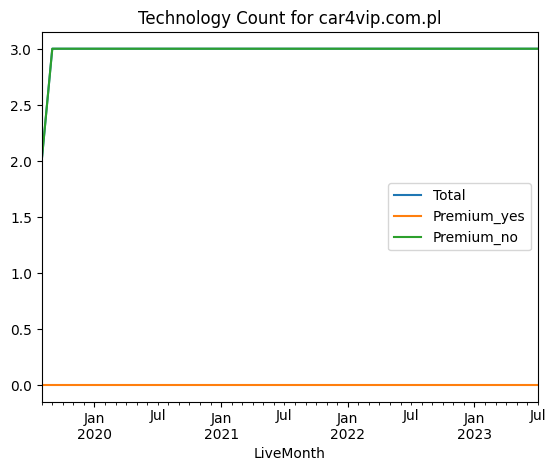

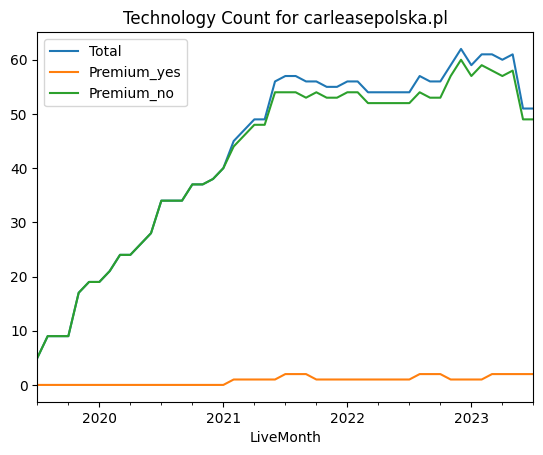

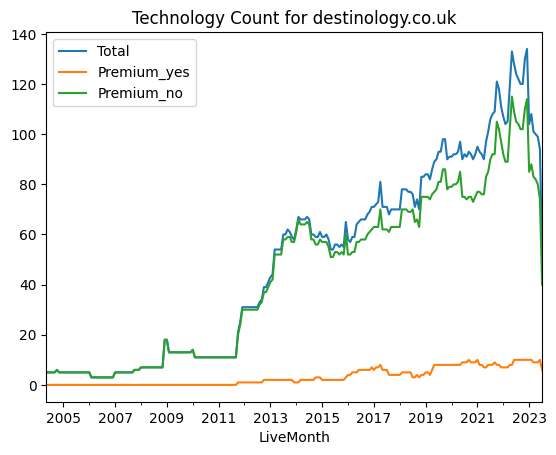

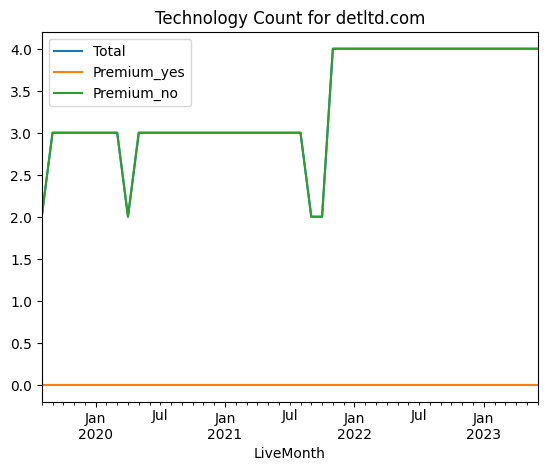

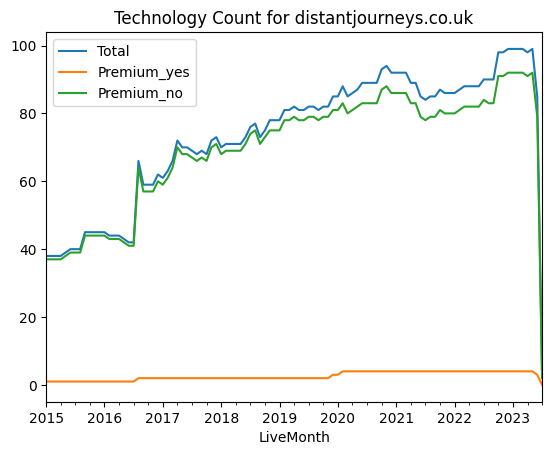

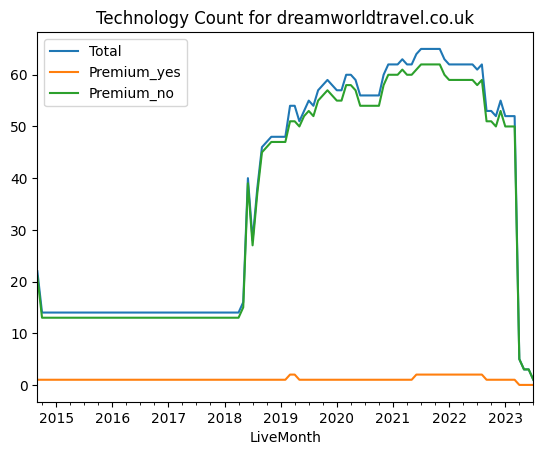

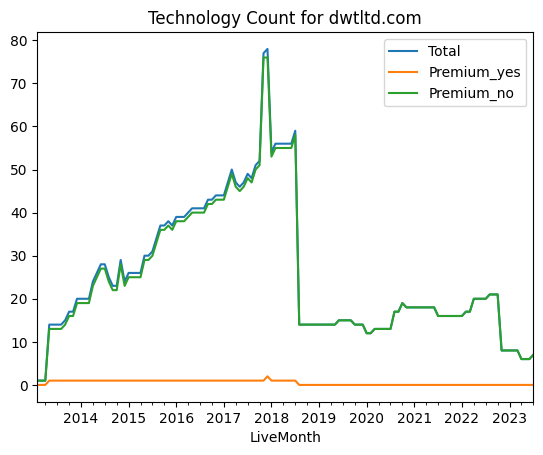

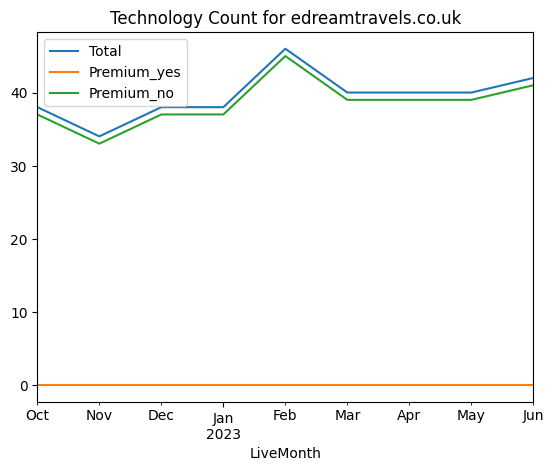

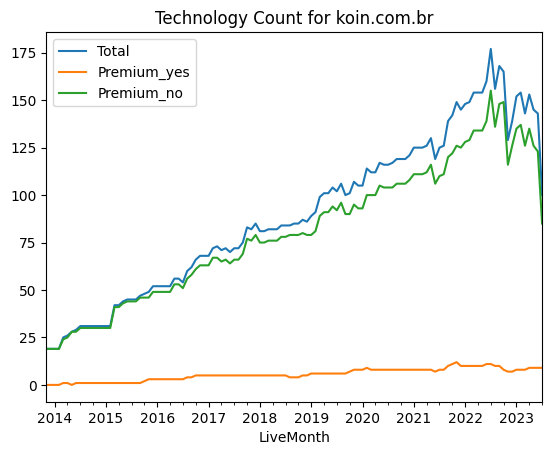

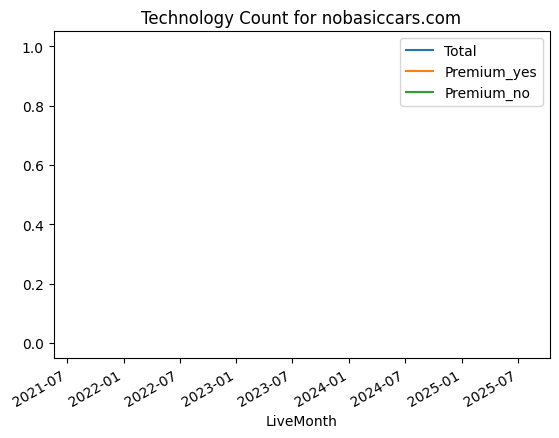

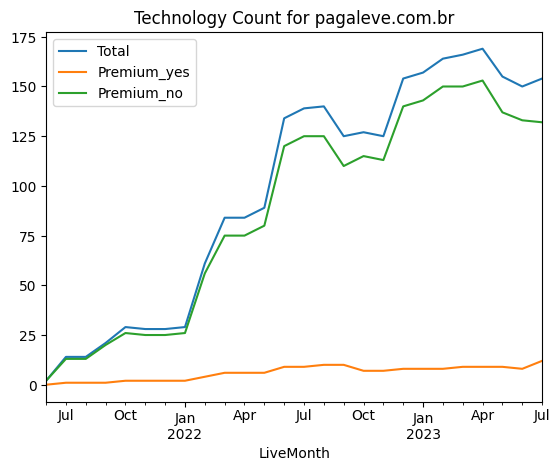

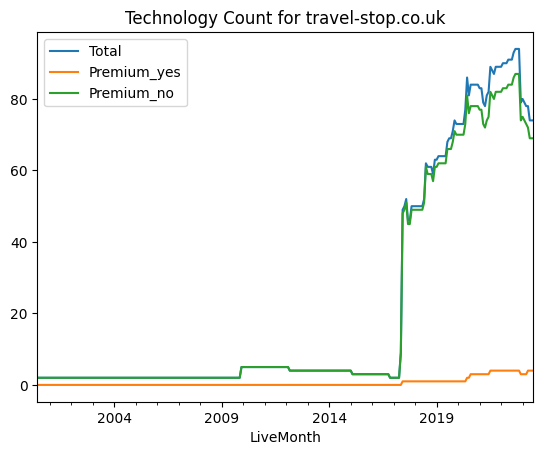

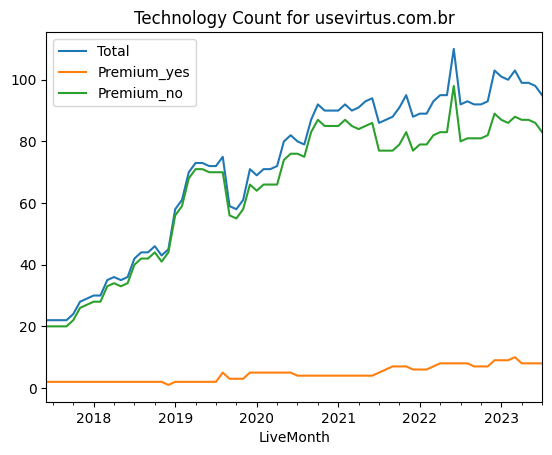

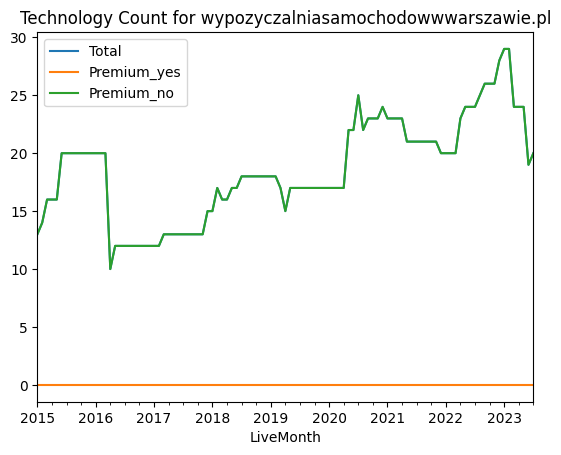

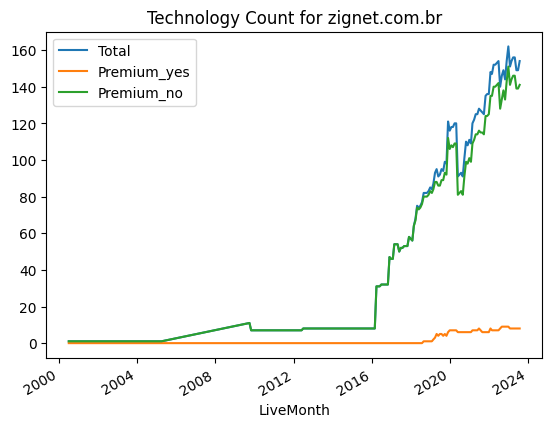

In [106]:
## TODO: Calc Rolling Change
## TODO: Remove insignificant technologies

def plot_active_monthly_tech_count_data(df, domain):
    df_domain = df.loc[df['Domain'] == domain]
    title = 'Technology Count for ' + domain
    df_domain.plot(title= title, x='LiveMonth', y=[ 'Total','Premium_yes', 'Premium_no'])

for domain in premium_count_data['Domain'].unique():
    plot_active_monthly_tech_count_data(premium_count_data, domain)



### Technology Usage - Auto

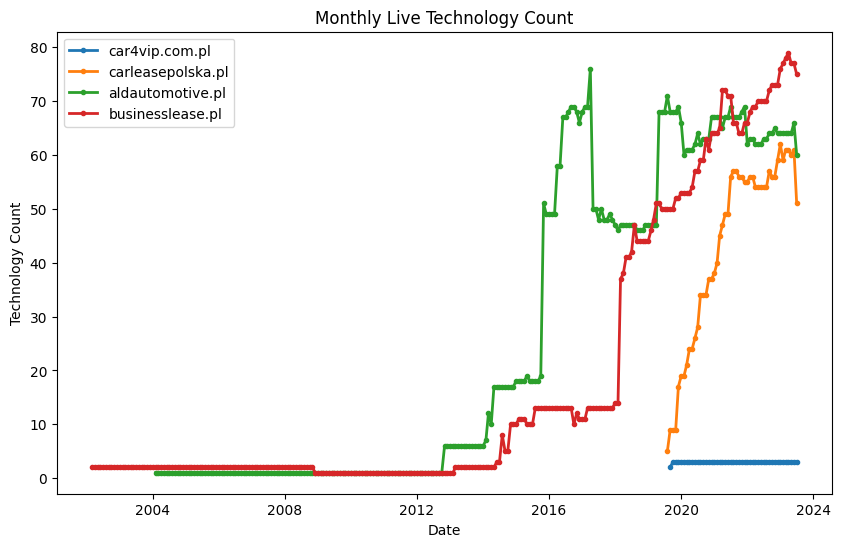

In [107]:
plot_tech_count_over_time_for_domains(premium_count_data, domains_auto)

### Technology Usage - Travel

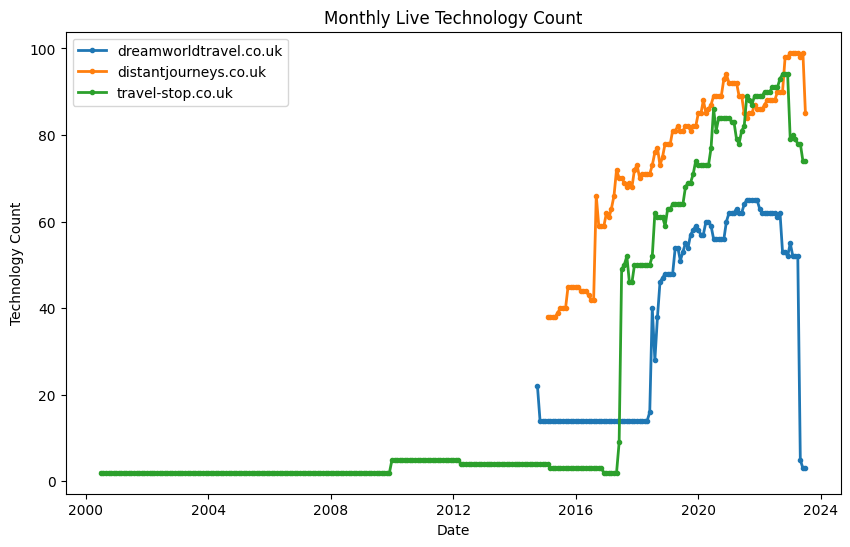

In [108]:
plot_tech_count_over_time_for_domains(premium_count_data, domains_travel)

### Technology Usage - Fintech

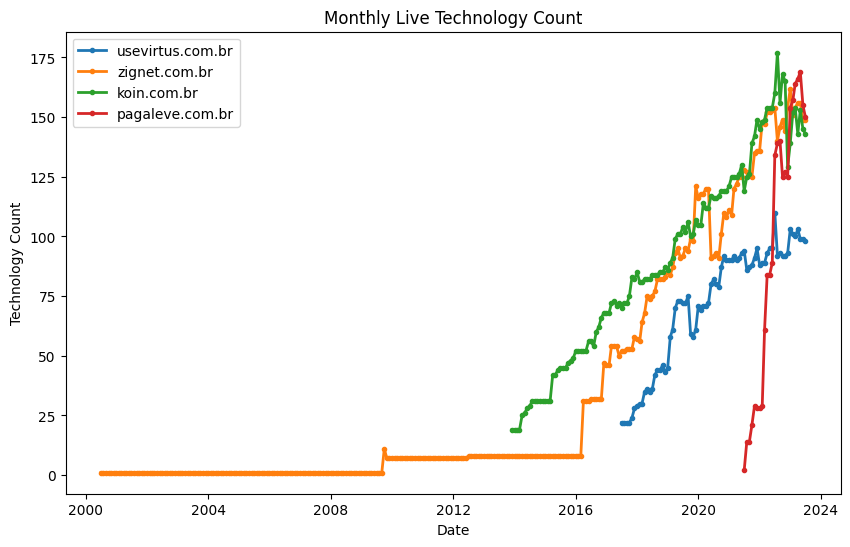

In [109]:
plot_tech_count_over_time_for_domains(premium_count_data, domains_fintech)